# Scenario 7 modelling

A combination of scenarios 3 and 5

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily 
import palettable.matplotlib as palmpl
import matplotlib.pyplot as plt
import matplotlib.cm
import mapclassify
import husl
import seaborn as sns

from utils import legendgram
import demoland_engine

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_91257/897323822.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
data_folder = "/Users/martin/Library/CloudStorage/OneDrive-SharedLibraries-TheAlanTuringInstitute/Daniel Arribas-Bel - demoland_data"

In [3]:
df = demoland_engine.get_empty()
df.head()

signature_type   use greenspace job_types
geo_code                                           
E00042786           None  None       None      None
E00042707           None  None       None      None
E00042703           None  None       None      None
E00042782           None  None       None      None
E00042789           None  None       None      None

In [4]:
%%time
default = demoland_engine.get_indicators(df, random_seed=42)

CPU times: user 4.2 s, sys: 446 ms, total: 4.65 s
Wall time: 4.58 s


In [5]:
geom = gpd.read_parquet(f"{data_folder}/processed/interpolated/all_oa.parquet")

In [6]:
oa_key = pd.read_parquet(f"{data_folder}/sampling/oa_key.parquet")

In [7]:
reg_urb = oa_key[oa_key.primary_type == "Regional urbanity"]
loc_urb = oa_key[oa_key.primary_type == "Local urbanity"]
dense_nei = oa_key[oa_key.primary_type == "Dense urban neighbourhoods"]

In [8]:
only_adjacent = geom[geom.geo_code.isin(dense_nei.index)].sjoin(geom[geom.geo_code.isin(loc_urb.index)]).geo_code_left

In [9]:
all_changes = np.concatenate([reg_urb.index, loc_urb.index, only_adjacent])

In [10]:
parks = ["E00042873", "E00042595", "E00042594", "E00175564", "E00042584", "E00042654"]

In [11]:
only_adjacent[~only_adjacent.isin(parks)]

63      E00042664
705     E00042125
784     E00042134
63      E00042664
194     E00042658
          ...    
3371    E00041873
3372    E00041870
3521    E00041858
3372    E00041870
3540    E00041851
Name: geo_code_left, Length: 217, dtype: object

In [12]:
df.loc[loc_urb.index.drop(parks, "ignore"), "signature_type"] = 13
df.loc[loc_urb.index.drop(parks, "ignore"), "signature_type"] = 12
df.loc[only_adjacent[~only_adjacent.isin(parks)], "signature_type"] = 11

In [13]:
brownfield_OAs = gpd.read_file(f"{data_folder}/scenarios/OAs_tynewear_contains-brownfield.gpkg")

In [14]:
df.loc[df.index.isin(brownfield_OAs.geo_code), "greenspace"] = .9

In [15]:
vars, jobs, gsp = demoland_engine.sampling.get_data(df, random_seed=42)

In [16]:
jobs[jobs<0] = -1 * (jobs[jobs<0] * .5)

In [17]:
vars = vars.rename(columns={"population_estimate": "population"})
aq = demoland_engine.predictors.air_quality_predictor.predict(vars)
hp = demoland_engine.predictors.house_price_predictor.predict(vars)
ja = demoland_engine.predictors.accessibility.job_accessibility(jobs, "walk")
gs = demoland_engine.predictors.accessibility.greenspace_accessibility(gsp, "walk")
ja = ja.to_pandas()[df.index].values
gs = gs.to_pandas()[df.index].values

changed_7 = pd.DataFrame(
    {
        "air_quality": aq,
        "house_price": hp,
        "job_accessibility": ja,
        "greenspace_accessibility": gs,
    },
    index=df.index,
)

In [18]:
%%time
# changed_7 = demoland_engine.get_indicators(df)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


In [19]:
changed_7

air_quality  house_price  job_accessibility  \
geo_code                                                 
E00042786    17.545723     7.515147        2313.000000   
E00042707    16.223658     8.070356       12862.000000   
E00042703    16.387146     7.610284        1548.000000   
E00042782    17.483856     7.478284        3310.000000   
E00042789    17.250893     7.390862        2267.000000   
...                ...          ...                ...   
E00041811    17.842647     7.267136        1370.000000   
E00041818    13.274783     7.555527        1750.000000   
E00041898    14.653236     7.522343        2310.000000   
E00041819    13.017931     7.378932        1216.000000   
E00041388    16.780241     7.158129        2777.694481   

           greenspace_accessibility  
geo_code                             
E00042786             273920.095000  
E00042707             298640.165450  
E00042703             505787.490500  
E00042782             253491.992400  
E00042789             219076.325550  
...                             ...  
E00041811             438944.147500  
E00041818             369786.865900  
E00041898             232015.331750  
E00041819             378888.942700  
E00041388             427960.837123  

[3795 rows x 4 columns]

## Maps

You can plot the two results.

In [20]:
geom = gpd.read_parquet(f"{data_folder}/processed/interpolated/all_oa.parquet")

In [21]:
from shapely.geometry import box

bds = geom.total_bounds
extent = gpd.GeoSeries([box((bds[0] - 7000), bds[1], bds[2] + 7000, bds[3])], crs=geom.crs).to_crs(3857)

### Air quality

Text(0.5, 1.0, 'baseline air quality')

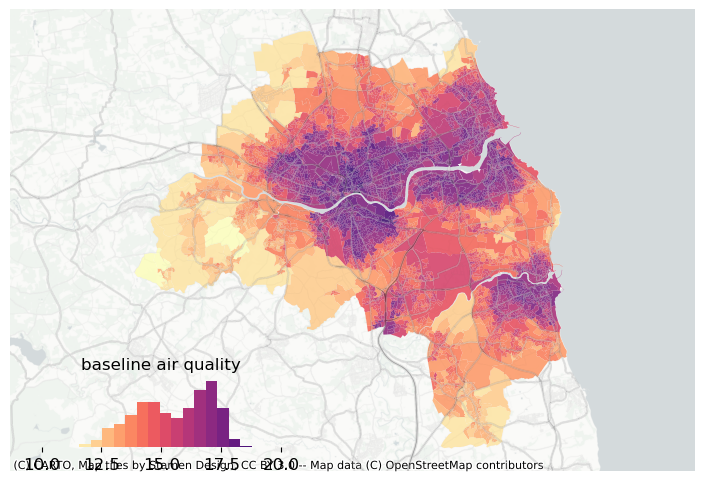

In [22]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.EqualInterval(default.air_quality.values, k=20).bins

legendgram(
    f,
    ax,
    default.air_quality.values,
    bins,
    pal=palmpl.Magma_20_r,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=default.air_quality.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="magma_r")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline air quality")


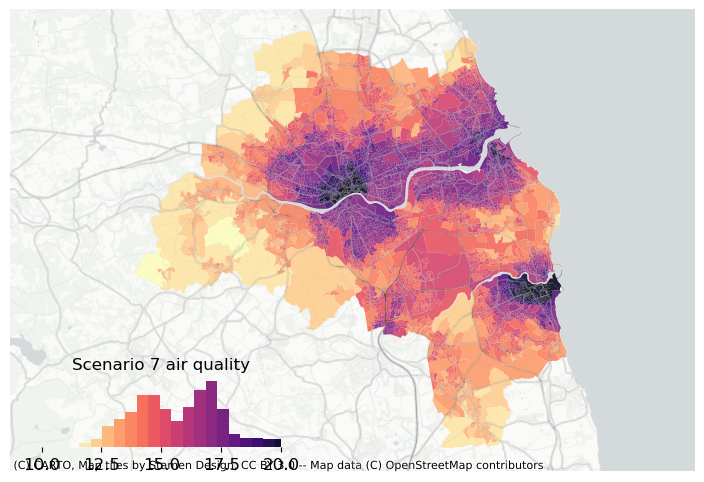

In [23]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    changed_7.air_quality.values,
    bins,
    pal=palmpl.Magma_20_r,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=changed_7.air_quality.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="magma_r")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 7 air quality")
plt.savefig(f"{data_folder}/scenarios/figures/scenario7_air_quality.png")

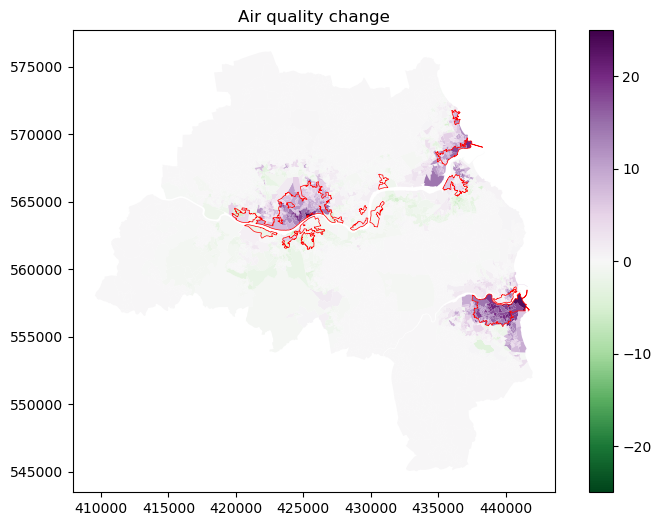

In [24]:
ax = geom.plot((changed_7.air_quality.values - default.air_quality.values) / default.air_quality.values * 100, legend=True, cmap="PRGn_r", vmin=-25, vmax=25, figsize=(9, 6))
geom[(geom.geo_code.isin(all_changes) & ~geom.geo_code.isin(parks)) | geom.geo_code.isin(brownfield_OAs.geo_code)].dissolve().boundary.plot(ax=ax, color="red", linewidth=.5)
ax.set_title("Air quality change")
plt.savefig(f"{data_folder}/scenarios/figures/scenario7_air_quality_diff.png")

### House price

Text(0.5, 1.0, 'baseline house price')

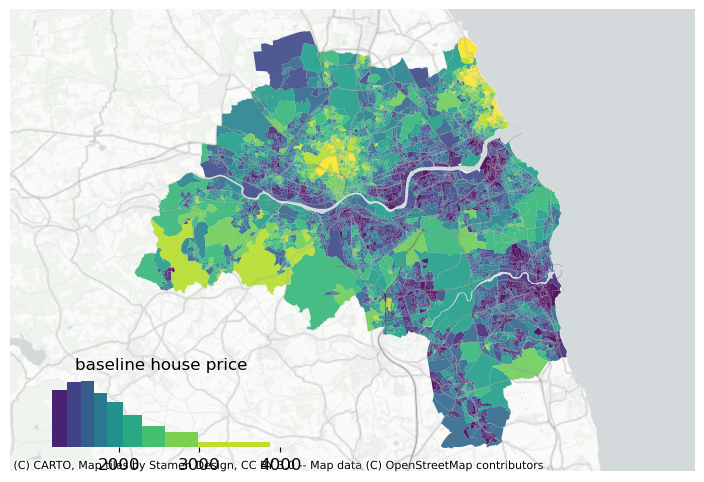

In [25]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(np.exp(default["house_price"].values), k=10).bins

legendgram(
    f,
    ax,
    np.exp(default.house_price.values),
    bins,
    pal=palmpl.Viridis_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=np.exp(default.house_price.values)).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="viridis")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline house price")


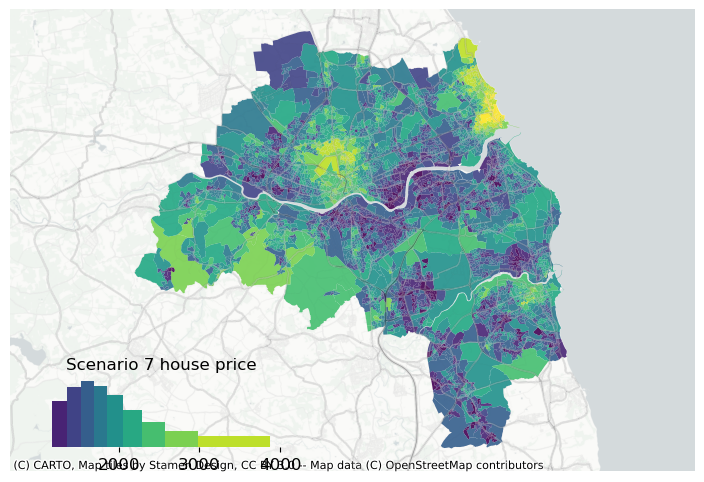

In [26]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    np.exp(changed_7.house_price.values),
    bins,
    pal=palmpl.Viridis_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=np.exp(changed_7.house_price.values)).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="viridis")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 7 house price")
plt.savefig(f"{data_folder}/scenarios/figures/scenario7_house_price.png")


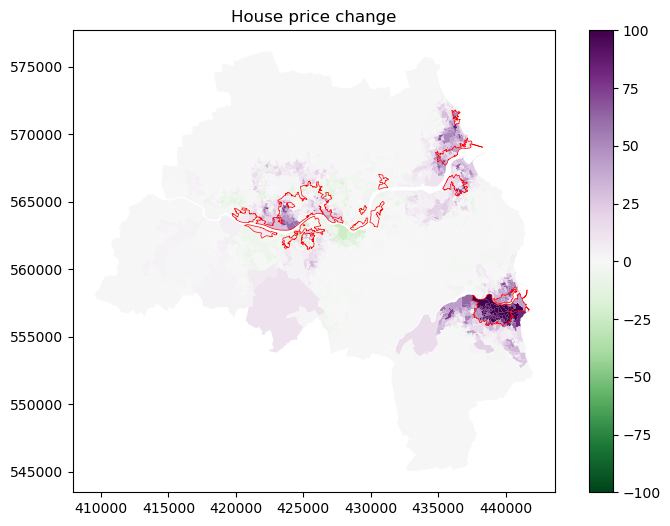

In [27]:
ax = geom.plot((np.exp(changed_7.house_price.values) - np.exp(default.house_price.values)) / np.exp(default.house_price.values) * 100, legend=True, cmap="PRGn_r", vmin=-100, vmax=100, figsize=(9, 6))
geom[(geom.geo_code.isin(all_changes) & ~geom.geo_code.isin(parks)) | geom.geo_code.isin(brownfield_OAs.geo_code)].dissolve().boundary.plot(ax=ax, color="red", linewidth=.5)
ax.set_title("House price change")
plt.savefig(f"{data_folder}/scenarios/figures/scenario7_house_price_diff.png")


### Job accessibility

Text(0.5, 1.0, 'baseline job accessibility')

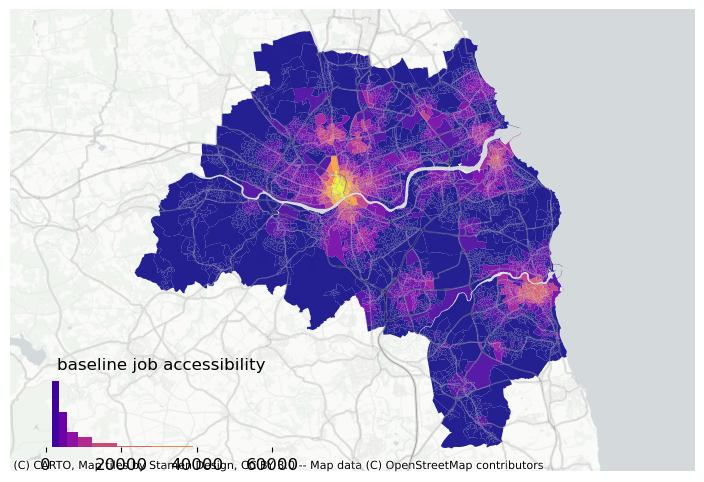

In [28]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(default.job_accessibility.values, k=10).bins

legendgram(
    f,
    ax,
    default.job_accessibility.values,
    bins,
    pal=palmpl.Plasma_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=default.job_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="plasma")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline job accessibility")


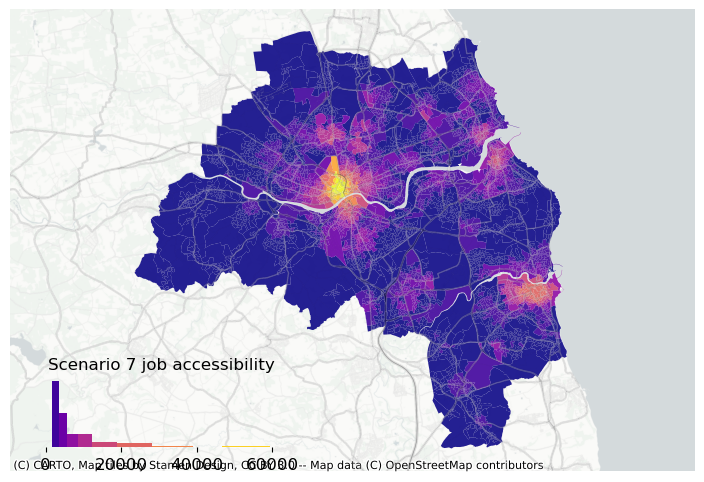

In [29]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    changed_7.job_accessibility.values,
    bins,
    pal=palmpl.Plasma_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=changed_7.job_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="plasma")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 7 job accessibility")
plt.savefig(f"{data_folder}/scenarios/figures/scenario7_job_acc.png")


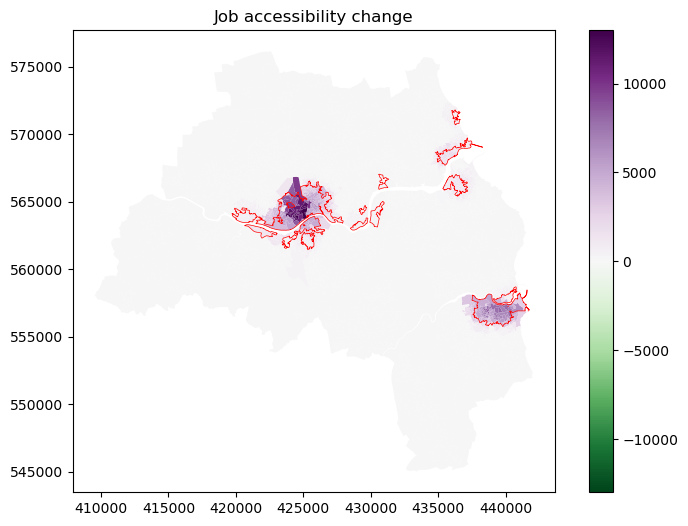

In [30]:
ax = geom.plot((changed_7.job_accessibility.values - default.job_accessibility.values), legend=True, cmap="PRGn_r", figsize=(9, 6), vmin=-13000, vmax=13000)
geom[(geom.geo_code.isin(all_changes) & ~geom.geo_code.isin(parks)) | geom.geo_code.isin(brownfield_OAs.geo_code)].dissolve().boundary.plot(ax=ax, color="red", linewidth=.5)
ax.set_title("Job accessibility change")
plt.savefig(f"{data_folder}/scenarios/figures/scenario7_job_acc_diff.png")

### Greenspace accessibility

Text(0.5, 1.0, 'baseline green space accessibility')

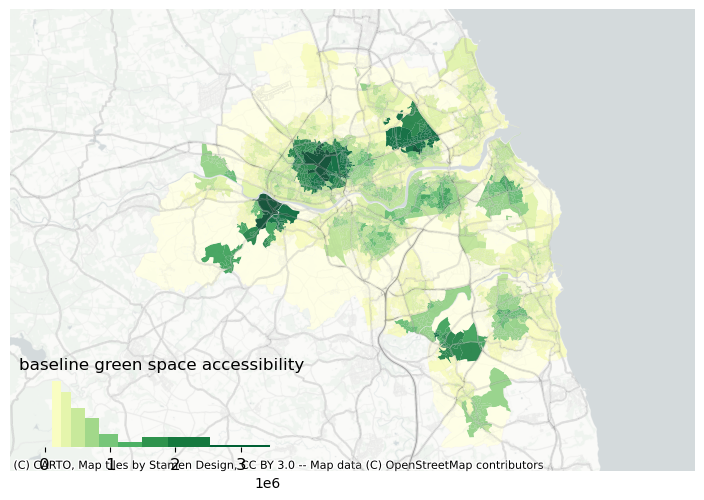

In [31]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(default.greenspace_accessibility.values, k=10).bins

legendgram(
    f,
    ax,
    default.greenspace_accessibility.values,
    bins,
    pal=matplotlib.cm.get_cmap('YlGn'),
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=default.greenspace_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="YlGn")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline green space accessibility")


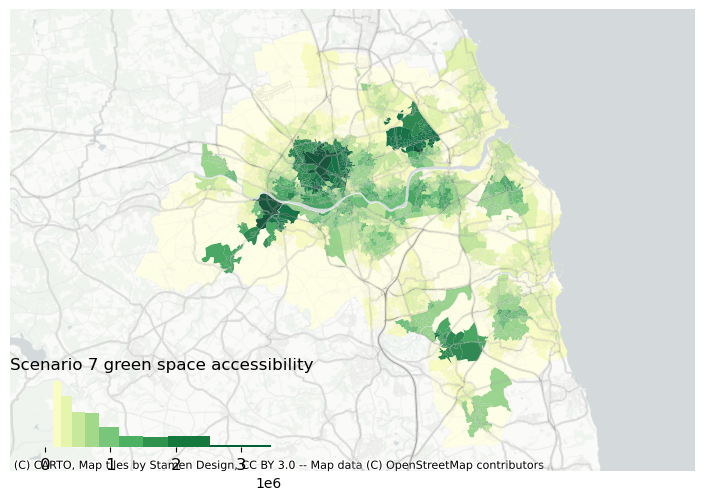

In [32]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    changed_7.greenspace_accessibility.values,
    bins,
    pal=matplotlib.cm.get_cmap('YlGn'),
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=changed_7.greenspace_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="YlGn")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 7 green space accessibility")
plt.savefig(f"{data_folder}/scenarios/figures/scenario7_gs_acc.png")

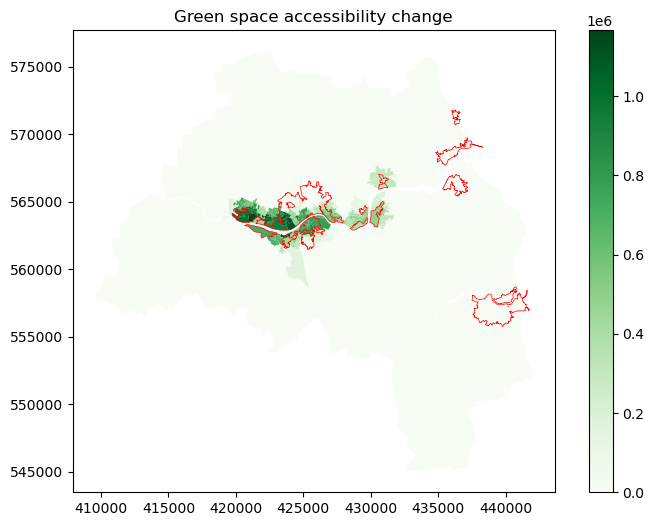

In [33]:
ax = geom.plot((changed_7.greenspace_accessibility.values - default.greenspace_accessibility.values), legend=True, cmap="Greens", figsize=(9, 6))
geom[(geom.geo_code.isin(all_changes) & ~geom.geo_code.isin(parks)) | geom.geo_code.isin(brownfield_OAs.geo_code)].dissolve().boundary.plot(ax=ax, color="red", linewidth=.5)
ax.set_title("Green space accessibility change")
plt.savefig(f"{data_folder}/scenarios/figures/scenario7_gs_acc_diff.png")